# Importing Libraries

In [38]:
!pip install gtts

In [42]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import json
import string
import nltk
import random
import pickle
from io import BytesIO
from keras.utils import plot_model
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gtts import gTTS
from IPython.display import Audio, display

In [12]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Loading Content

Content is a JSON file containing tag, input and response. What we going to do is predict tag based on input and give random answer from responses.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%pwd

'/content'

In [5]:
%cd /content/drive/MyDrive/ML-Projects/Chatbot using LSTM/model

/content/drive/MyDrive/ML-Projects/Chatbot using LSTM/model


In [13]:
intents = json.loads(open('intents.json').read())

In [7]:
intents

{'intents': [{'tag': 'salam',
   'patterns': ['Hai, apa kabar?',
    'Selamat pagi!',
    'hallo',
    'hai',
    'halo',
    'hei',
    'hi',
    'hy',
    'pagi',
    'morning',
    'siang',
    'afternoon',
    'sore',
    'malam',
    'bro',
    'sis',
    'kawan'],
   'responses': ['Halo! Saya baik, terima kasih. Bagaimana saya bisa membantu Anda hari ini?',
    'Hai! Selamat datang di situs kami. Ada yang bisa saya bantu?',
    'Halo! Jangan ragu bertanya jika ada yang ingin Anda ketahui.',
    'Helo! Kadekbot di sini untuk membantu. Ada pertanyaan atau bantuan yang Anda butuhkan?']},
  {'tag': 'identitas_bot',
   'patterns': ['Apakah kamu manusia atau robot?'],
   'responses': ['Saya adalah bot cerdas yang siap membantu Anda. Bagaimana saya bisa mendukung Anda hari ini?']},
  {'tag': 'pertanyaan_produk',
   'patterns': ['Halo, saya memiliki pertanyaan tentang produk Anda.'],
   'responses': ['Tentu, saya senang membantu! Apa yang ingin Anda ketahui lebih lanjut tentang produk ka

In [14]:
tags = []
inputs = []
responses = {}
words = []
classes = []
documents = []
ignore_words = ['?','!',':','&','%','@','/']

for intent in intents['intents']:
    responses[intent['tag']] = intent["responses"]
    for lines in intent['patterns']:
        inputs.append(lines)
        tags.append(intent['tag'])
        for pattern in intent['patterns']:
            w = nltk.word_tokenize(pattern)
            words.extend(w)
            documents.append((w, intent['tag']))
            # add to our classes list
            if intent['tag'] not in classes:
                classes.append(intent['tag'])

print("this is tags",tags)
print("this is input",inputs)
print("this is responses",responses)

this is tags ['salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'salam', 'identitas_bot', 'pertanyaan_produk', 'selamat_tinggal', 'selamat_tinggal', 'selamat_tinggal', 'selamat_tinggal', 'selamat_tinggal', 'ucapan_terima_kasih', 'ucapan_terima_kasih', 'ucapan_terima_kasih', 'ucapan_terima_kasih', 'ucapan_terima_kasih', 'ucapan_terima_kasih', 'jam_kerja', 'informasi_umum', 'produk_baru', 'panduan_pengguna', 'produk_terlaris', 'produk_ramah_lingkungan', 'ketersediaan_warna', 'ketersediaan_warna', 'perawatan_produk', 'perbandingan_produk', 'perbandingan_produk', 'garansi_produk', 'ulasan_pelanggan', 'target_pasar', 'panduan_ukuran', 'demo_produk', 'sertifikasi_keamanan', 'rekomendasi_produk', 'diskon', 'waktu_pengiriman', 'keunggulan_produk', 'cara_pemesanan', 'proses_pembayaran', 'batasan_pemesanan', 'ubah_pesanan', 'pembatalan_pesanan', 'keterlambatan_pesanan', 'status_pesanan', 'biaya_pengirim

# Data Preprocessing

Now we construct a dataframe consist of inputs and thier respective tags.

In [15]:
data = pd.DataFrame({"inputs":inputs,
                    "tags":tags})

In [36]:
data

,inputs,tags
0,"Hai, apa kabar?",salam
1,Selamat pagi!,salam
2,hallo,salam
3,hai,salam
4,halo,salam
...,...,...
146,Prosedur pembatalan pesanan,pembatalan_pesanan
147,Bagaimana cara mengembalikan produk?,pengembalian_produk
148,Prosedur pengembalian barang,pengembalian_produk
149,Saya ingin mengembalikan produk,pengembalian_produk


Removing punctuations and converting text to lower case

In [16]:
data["inputs"] = data["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])

In [17]:
data["inputs"] = data["inputs"].apply(lambda wrd: ''.join(wrd))

In [39]:
data

,inputs,tags
0,hai apa kabar,salam
1,selamat pagi,salam
2,hallo,salam
3,hai,salam
4,halo,salam
...,...,...
146,prosedur pembatalan pesanan,pembatalan_pesanan
147,bagaimana cara mengembalikan produk,pengembalian_produk
148,prosedur pengembalian barang,pengembalian_produk
149,saya ingin mengembalikan produk,pengembalian_produk


# Lemmatization

In [18]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print(len(words), "uniqe lemmatized words", words)

287 uniqe lemmatized words [',', '.', 'a', 'ada', 'afternoon', 'akan', 'aktif', 'aktifkan', 'akun', 'alamat', 'aman', 'anda', 'antara', 'apa', 'apakah', 'aplikasi', 'atas', 'atau', 'b', 'bagaimana', 'bagi', 'bantuanmu', 'banyak', 'barang', 'baru', 'batasan', 'beberapa', 'berapa', 'berlaku', 'berlangganan', 'bertemu', 'besar', 'besar-besaran', 'biaya', 'bisa', 'bisakah', 'bro', 'buletin', 'cara', 'caranya', 'cek', 'celah', 'cocok', 'cooky', 'dalam', 'dan', 'dapat', 'data', 'datang', 'demo', 'dengan', 'di', 'dibandingkan', 'digabung', 'digunakan', 'dihubungi', 'dijaga', 'dijamin', 'dijual', 'dikonfirmasi', 'diluncurkan', 'diproses', 'diretas', 'dirilis', 'disarankan', 'diskon', 'diterima', 'ditumpuk', 'dua', 'eksklusif', 'email', 'enkripsi', 'faktor', 'faktur', 'fitur', 'garansi', 'goodbye', 'hai', 'hallo', 'halo', 'harga', 'hari', 'hari-hari', 'harus', 'hei', 'hi', 'hy', 'informasi', 'ingin', 'ini', 'jam', 'jangka', 'jenis', 'jika', 'jumlah', 'jumpa', 'kabar', 'kamu', 'kapan', 'kartu', 

In [19]:
classes = sorted(list(set(classes)))
print(len(classes), 'classes',classes)
print(len(documents),'documents')

52 classes ['batasan_pemesanan', 'biaya_pengiriman', 'cara_pemesanan', 'cookie_privasi', 'data_pribadi', 'demo_produk', 'diskon', 'diskon_khusus', 'diskon_pelanggan_setia', 'diskon_produk', 'faktur', 'ganti_alamat', 'garansi_produk', 'identitas_bot', 'informasi_umum', 'jam_kerja', 'keamanan_akun', 'keamanan_data', 'keamanan_pembayaran', 'kebijakan_privasi', 'keterlambatan_pesanan', 'ketersediaan_warna', 'keunggulan_produk', 'kode_diskon', 'kwitansi', 'lapor_keamanan', 'metode_pembayaran', 'order_confirmation', 'panduan_pengguna', 'panduan_ukuran', 'pembatalan_pesanan', 'pengembalian_produk', 'pengguna_baru', 'perawatan_produk', 'perbandingan_produk', 'pertanyaan_produk', 'produk_baru', 'produk_ramah_lingkungan', 'produk_terlaris', 'proses_pembayaran', 'proses_pembelian', 'rekomendasi_produk', 'salam', 'sale_besar', 'selamat_tinggal', 'sertifikasi_keamanan', 'status_pesanan', 'target_pasar', 'ubah_pesanan', 'ucapan_terima_kasih', 'ulasan_pelanggan', 'waktu_pengiriman']
1085 documents


# Tokenizing and Padding

In [20]:
tokenizer = Tokenizer(num_words = 2000)

In [21]:
tokenizer.fit_on_texts(data["inputs"])

In [22]:
train = tokenizer.texts_to_sequences(data["inputs"])

In [62]:
train

[[67, 9, 107],
 [51, 68],
 [108],
 [67],
 [69],
 [109],
 [110],
 [111],
 [68],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [119],
 [2, 120, 121, 24, 122],
 [69, 1, 70, 123, 32, 6, 17],
 [51, 124],
 [52, 125],
 [126],
 [52, 127, 128],
 [52, 129],
 [71, 72, 130, 131],
 [71, 72],
 [132],
 [133],
 [134, 135],
 [136, 137],
 [73, 138, 139, 17],
 [1, 22, 18, 37, 9, 7, 53, 1, 140],
 [2, 8, 6, 22, 7, 141, 142],
 [2, 8, 54, 23, 4, 6, 11],
 [6, 74, 7, 143, 144, 33, 11],
 [2, 145, 17, 146, 147],
 [3, 5, 1, 75, 148, 76, 4, 6, 11],
 [2, 6, 149, 55, 56, 57, 76],
 [3, 5, 150, 6, 11],
 [9, 151, 152, 6, 153, 154, 6, 155],
 [3, 5, 156, 57, 6, 157, 158, 4, 77],
 [2, 8, 159, 4, 6, 11],
 [3, 5, 20, 160, 34, 4, 6, 11],
 [6, 11, 161, 4, 78],
 [2, 8, 54, 162, 4, 163, 17],
 [2, 8, 164, 165, 4, 6, 11],
 [2, 6, 11, 70, 166, 14],
 [2, 8, 6, 167, 7, 26, 17, 168],
 [2, 8, 10, 4, 27, 56, 79, 169],
 [170, 171, 58, 38, 172, 4, 6, 11],
 [9, 7, 39, 6, 11, 173, 174, 59, 6, 175, 18, 176],
 [3, 5, 1, 40, 6, 177

In [23]:
x_train = pad_sequences(train)

In [64]:
x_train

array([[  0,   0,   0, ...,  67,   9, 107],
       [  0,   0,   0, ...,   0,  51,  68],
       [  0,   0,   0, ...,   0,   0, 108],
       ...,
       [  0,   0,   0, ..., 104, 106, 285],
       [  0,   0,   0, ...,  31, 105,   6],
       [  0,   0,   0, ...,   4, 106,   6]], dtype=int32)

# Encoding the output

In [24]:
le = LabelEncoder()
y_train = le.fit_transform(data["tags"])
y_train

array([42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       13, 35, 44, 44, 44, 44, 44, 49, 49, 49, 49, 49, 49, 15, 14, 36, 28,
       38, 37, 21, 21, 33, 34, 34, 12, 50, 47, 29,  5, 45, 41,  6, 51, 22,
        2, 39,  0, 48, 30, 20, 46,  1, 11, 10, 24, 27, 27, 27,  9,  9,  9,
        9,  9,  9, 23, 23, 23, 43,  8,  8,  8,  8,  7, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 16,
       16, 16, 16, 16, 16, 18, 18, 18, 18, 25, 25, 25, 25, 19, 19, 19, 19,
        4,  4,  4,  4, 17, 17, 17, 17,  3,  3,  3,  3, 40, 40, 40, 40, 26,
       26, 26, 26, 46, 46, 46, 46, 30, 30, 30, 30, 31, 31, 31, 31])

In [25]:
input_shape = x_train.shape[1]
print(input_shape)

14


In [26]:
unique_words = len(tokenizer.word_index)
output_length = le.classes_.shape[0]
print("unique words: ", unique_words)
print("output length: ", output_length)

unique words:  285
output length:  52


# Building Neural Network

Here I am using Embedding layer and LSTM (Long Short term Memory) and 3 dense layers. Since we are predicting tags, so the output length will be the number of classes (tags), therefore using softmax activation in the last layer.

In [27]:
model = tf.keras.Sequential()
model.add(Input(shape=(input_shape,)))
model.add(Embedding(unique_words+1, 10, input_length= (input_shape,)))
model.add(LSTM(10, return_sequences=True))
model.add(Flatten())
# model.add(Dense(units= 10, activation='relu'))
# model.add(Dense(units= 5, activation='relu'))
model.add(Dense(units= output_length, activation='softmax'))

In [28]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer ='adam', metrics=['accuracy'])

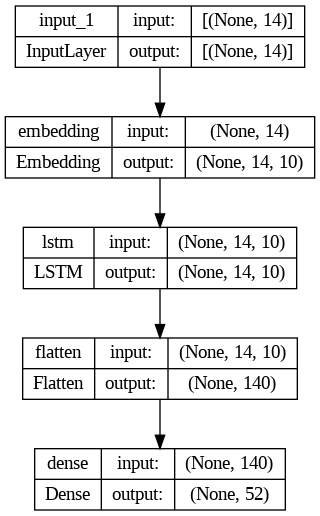

In [29]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 14, 10)            2860      
                                                                 
 lstm_2 (LSTM)               (None, 14, 10)            840       
                                                                 
 flatten_2 (Flatten)         (None, 140)               0         
                                                                 
 dense_6 (Dense)             (None, 52)                7332      
                                                                 
Total params: 11032 (43.09 KB)
Trainable params: 11032 (43.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training the Model

In [30]:
jarvis = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
5/5 [==============================] - 2s 8ms/step - loss: 3.9470 - accuracy: 0.0530
Epoch 2/400
5/5 [==============================] - 0s 6ms/step - loss: 3.9345 - accuracy: 0.1391
Epoch 3/400
5/5 [==============================] - 0s 6ms/step - loss: 3.9203 - accuracy: 0.1325
Epoch 4/400
5/5 [==============================] - 0s 6ms/step - loss: 3.8992 - accuracy: 0.1391
Epoch 5/400
5/5 [==============================] - 0s 6ms/step - loss: 3.8708 - accuracy: 0.1391
Epoch 6/400
5/5 [==============================] - 0s 6ms/step - loss: 3.8325 - accuracy: 0.1325
Epoch 7/400
5/5 [==============================] - 0s 6ms/step - loss: 3.7779 - accuracy: 0.1325
Epoch 8/400
5/5 [==============================] - 0s 6ms/step - loss: 3.7095 - accuracy: 0.1325
Epoch 9/400
5/5 [==============================] - 0s 6ms/step - loss: 3.6275 - accuracy: 0.1258
Epoch 10/400
5/5 [==============================] - 0s 7ms/step - loss: 3.5338 - accuracy: 0.1192
Epoch 11/400
5/5 [===========

AttributeError: ignored

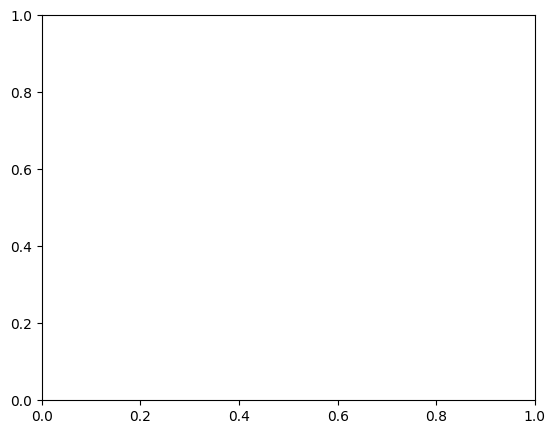

In [31]:
# # Plotting model Accuracy and Loss (Visualisasi plot Hasil Akurasi dan Loss)
# # Plot Akurasi
# plt.figure(figsize=(14, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train.history['accuracy'],label='Training Set Accuracy')
# plt.legend(loc='lower right')
# plt.title('Accuracy')
# # Plot Loss
# plt.subplot(1, 2, 2)
# plt.plot(train.history['loss'], label='Training Set Loss')
# plt.legend(loc='upper right')
# plt.title('loss')
# plt.show

In [33]:
# saving model
model.save("chat_model_01.h5", jarvis)

pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(le, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

# Chatting with bot

In [44]:
# Load the model
model = load_model('chat_model_01.h5')

# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the label encoder
with open('label_encoder.pickle', 'rb') as handle:
    le = pickle.load(handle)

print("Selamat datang di Chatbot, silahkan tanyakan kepada kami dengan pertanyaan 5W + 1H")
# Rest of your code
while True:
    textList = []
    user_input = input("🗿 You: ")
    prediction_input = []

    for letter in user_input:
        if letter not in string.punctuation:
            prediction_input.append(letter.lower())

    prediction_input = ''.join(prediction_input)
    textList.append(prediction_input)

    prediction_input = tokenizer.texts_to_sequences(textList)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    output = model.predict(prediction_input)
    output = output.argmax()

    response_tag = le.inverse_transform([output])[0]
    response_text = random.choice(responses[response_tag])
    print("Chatbot 🤖: ", random.choice(responses[response_tag]))
    # Convert text to speech and play it
    tts = gTTS(response_text, lang='id')
    tts.save("response.wav")
    time.sleep(0.08)

    # Display the audio using IPython.display
    display(Audio(filename="response.wav", autoplay=True))
    if response_tag == 'selamat_tinggal':
        break


Selamat datang di Chatbot, silahkan tanyakan kepada kami dengan pertanyaan 5W + 1H
🗿 You: hello


1/1 [==============================] - 0s 292ms/step
Chatbot 🤖:  Halo! Jangan ragu bertanya jika ada yang ingin Anda ketahui.


🗿 You: goodbye
1/1 [==============================] - 0s 14ms/step
Chatbot 🤖:  Sampai bertemu lagi! Jika Anda membutuhkan informasi tambahan, kami selalu siap membantu.


# Explanation

The chatbot is giving answers randomly from the reponses I have written against every tag. This is a simple chatbot without text analysis.

Best way to build a great chatbot is by using Bidirectioal RNN with LSTM. I will surely share when I have done working.

This model is predicting fine since the accuracy is good. But its capability is limited since it is just a simple Neural Network.